In [1]:
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pycocotools import mask as maskUtils
from sklearn.cluster import KMeans

In [35]:
MIN_AREA = 5000
RANDOM_SEED = 51
DATASET_LENGTH = 100

# Loading the dataset

In [3]:
with open('/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_train2017.json') as f:
    coco_data = json.load(f)

In [4]:
coco_data['annotations'][0]

{'segmentation': [[239.97,
   260.24,
   222.04,
   270.49,
   199.84,
   253.41,
   213.5,
   227.79,
   259.62,
   200.46,
   274.13,
   202.17,
   277.55,
   210.71,
   249.37,
   253.41,
   237.41,
   264.51,
   242.54,
   261.95,
   228.87,
   271.34]],
 'area': 2765.1486500000005,
 'iscrowd': 0,
 'image_id': 558840,
 'bbox': [199.84, 200.46, 77.71, 70.88],
 'category_id': 58,
 'id': 156}

# Finding out valid images to be used for camouflage dataset creation

In [5]:
# Instead of MIN_KEYPOINTS, filter for objects with good segmentation masks
valid_anns = []
for annotation in coco_data['annotations']:
    if annotation['area'] > MIN_AREA and len(annotation['segmentation']) > 0:  # Filter by size and valid mask
        valid_anns.append(annotation)

In [18]:
#Finding image corresponding to annotation using image id
imgid_to_filename_dict = {img['id']: img['file_name'] for img in coco_data['images']}

# Helper functions and visualisation

3 helper functions: extract_object_foreground(), extract_colour_palette(), and visualise_colour_palette()

## 1. Visualising what extract_foreground() function does

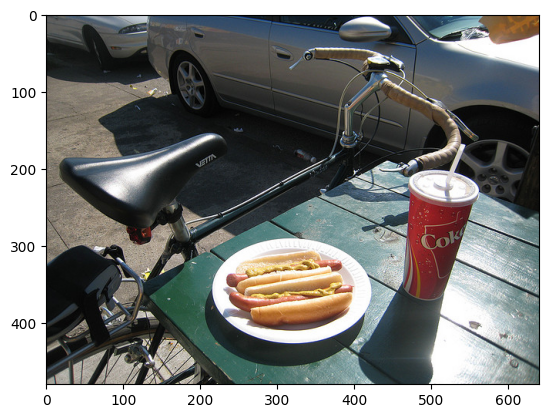

In [19]:
imgid_to_data_dict = {}

ann = valid_anns[0]
img_id = ann['image_id']
filename = imgid_to_filename_dict[img_id]

img_path = f'/kaggle/input/coco-2017-dataset/coco2017/train2017/{filename}'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

h, w = img.shape[:2]


unprocessed_coco_mask = ann['segmentation']
rles = None
if type(ann['segmentation']) == list:
    # Polygon format - convert to RLE
    rles = maskUtils.frPyObjects(unprocessed_coco_mask, h, w)
    rle = maskUtils.merge(rles)
elif type(annotation['segmentation']['counts']) == list:
    # Uncompressed RLE
    rle = maskUtils.frPyObjects(annotation['segmentation'], h, w)
else:
    # Compressed RLE
    rle = annotation['segmentation']

# Decode RLE to binary mask
mask = maskUtils.decode(rle)


# Create foreground image with white background
foreground = img.copy()
foreground[mask == 0] = [255, 255, 255]  # White background where mask is 0

plt.imshow(img)

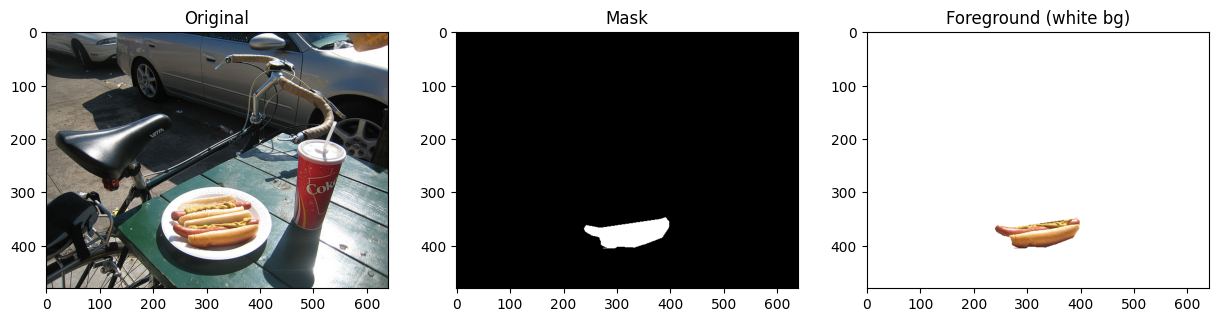

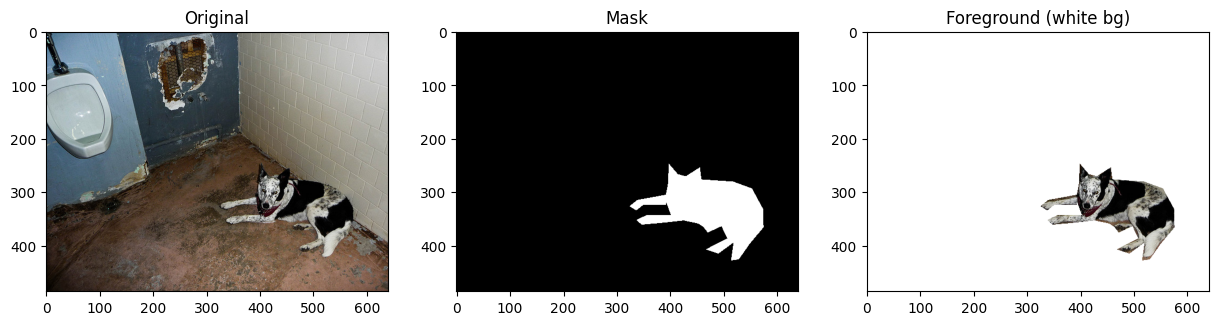

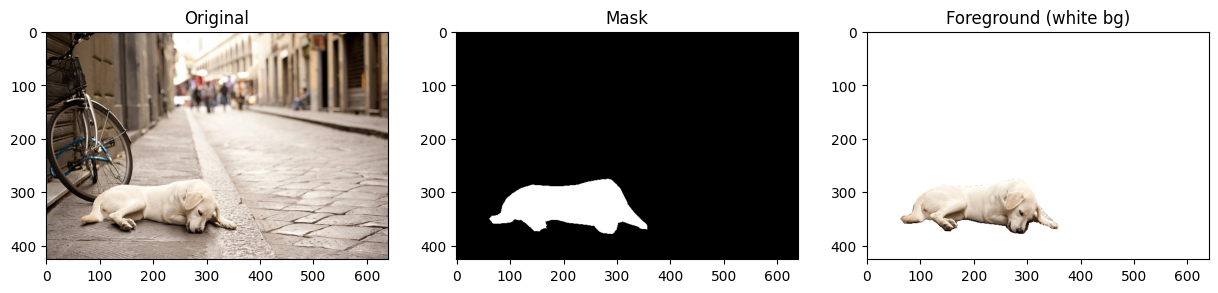

In [8]:
# After loading COCO data
for i in range(3):
    ann = valid_anns[i]
    img_id = ann['image_id']
    filename = imgid_to_filename_dict[img_id]
    
    img_path = f'/kaggle/input/coco-2017-dataset/coco2017/train2017/{filename}'
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Extract foreground
    foreground, mask = extract_object_foreground(img, ann)
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img)
    axes[0].set_title("Original")
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title("Mask")
    axes[2].imshow(foreground)
    axes[2].set_title("Foreground (white bg)")
    plt.show()

In [7]:
def extract_object_foreground(img, annotation):
    """Extract object with white background using COCO segmentation"""
    """
    segmentation masks can be stored in multiple compressed modes like
    1. Polygon mask: Keypoints are found -> Neighbouring keypoints connected by line along contours of objects
    2. Uncompressed RLE (Run Length Encoding): Flatten matrix and then write no. of zeroes & no. of ones and so on till end
    3. Compressed RLE
    """
    """
    Polygon mask looks like this: 
    "segmentation": [
      [x1,y1,x2,y2,...],      # polygon for head  [list of coordinates representing vertices of polygon]
      [x1,y1,x2,y2,...]       # polygon for torso
    ]
    Uncompressed RLE looks like this:
    "segmentation": {
      "size": [h, w],
      "counts": [runs...]
    }
    "segmentation": {
      "size": [h, w],
      "counts": "aSd31ac...."   #string instead of combination of zeros and ones in a separate encoding format for efficiency
    }
    """
    
    
    # Get image dimensions
    h, w = img.shape[:2]
    
    # Handle different segmentation formats
    if type(annotation['segmentation']) == list:
        # Polygon format - convert to RLE
        rles = maskUtils.frPyObjects(annotation['segmentation'], h, w)     #
        rle = maskUtils.merge(rles)
    elif type(annotation['segmentation']['counts']) == list:
        # Uncompressed RLE
        rle = maskUtils.frPyObjects(annotation['segmentation'], h, w)
    else:
        # Compressed RLE
        rle = annotation['segmentation']
    
    # Decode RLE to binary mask
    mask = maskUtils.decode(rle)
    
    # Create foreground image with white background
    foreground = img.copy()
    foreground[mask == 0] = [255, 255, 255]  # White background where mask is 0
    
    return foreground, mask

## 2. Visualising extract colour palette functions

In [20]:
from sklearn.cluster import KMeans

background_pixels = img[mask == 0].reshape(-1, 3)
answer = None
n_colors = 5

if len(background_pixels) < n_colors:
    answer = np.zeros((n_colors, 3))

kmeans = KMeans(n_clusters=n_colors, random_state=42)
kmeans.fit(background_pixels)
palette = kmeans.cluster_centers_.astype(int)
answer = palette
answer

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([[242, 243, 241],
       [ 75,  78,  79],
       [ 26,  29,  29],
       [175, 180, 174],
       [128, 131, 123]])

In [10]:
from sklearn.cluster import KMeans

def extract_color_palette(img, mask, n_colors=5):
    """Extract dominant colors from background (non-object regions)"""
    background_pixels = img[mask == 0].reshape(-1, 3)
    
    if len(background_pixels) < n_colors:
        return np.zeros((n_colors, 3))
    
    kmeans = KMeans(n_clusters=n_colors, random_state=RANDOM_SEED)
    kmeans.fit(background_pixels)
    palette = kmeans.cluster_centers_.astype(int)
    return palette

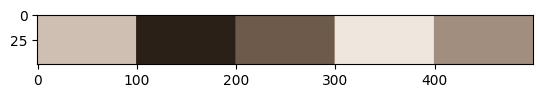

In [11]:
answer = None
height = 50
width = 100

palette_img = np.zeros((height, width * len(palette), 3), dtype=np.uint8)
for i, color in enumerate(palette):
    palette_img[:, i*width:(i+1)*width] = color
answer = palette_img

plt.imshow(answer)


In [12]:
def visualize_palette(palette, width=100, height=50):
    """Create visual representation of color palette"""
    palette_img = np.zeros((height, width * len(palette), 3), dtype=np.uint8)
    for i, color in enumerate(palette):
        palette_img[:, i*width:(i+1)*width] = color
    return palette_img

In [13]:
def visualize_sample(original, foreground, palette_img, img_id):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(original)
    axes[0].set_title(f"Original (ID: {img_id})")
    axes[0].axis('off')
    
    axes[1].imshow(foreground)
    axes[1].set_title("Object Foreground")
    axes[1].axis('off')
    
    axes[2].imshow(palette_img)
    axes[2].set_title("Background Color Palette")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


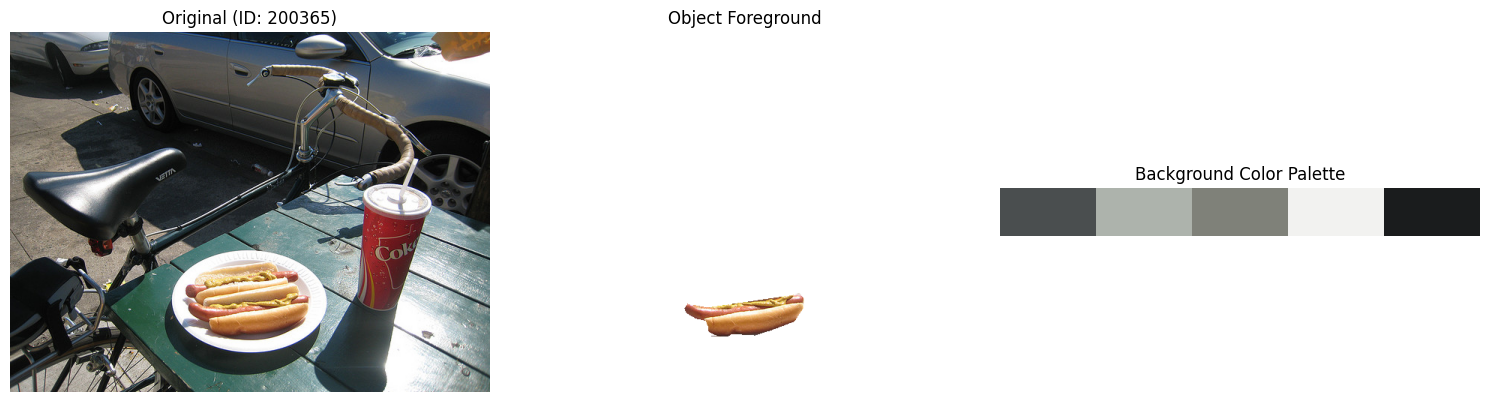

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


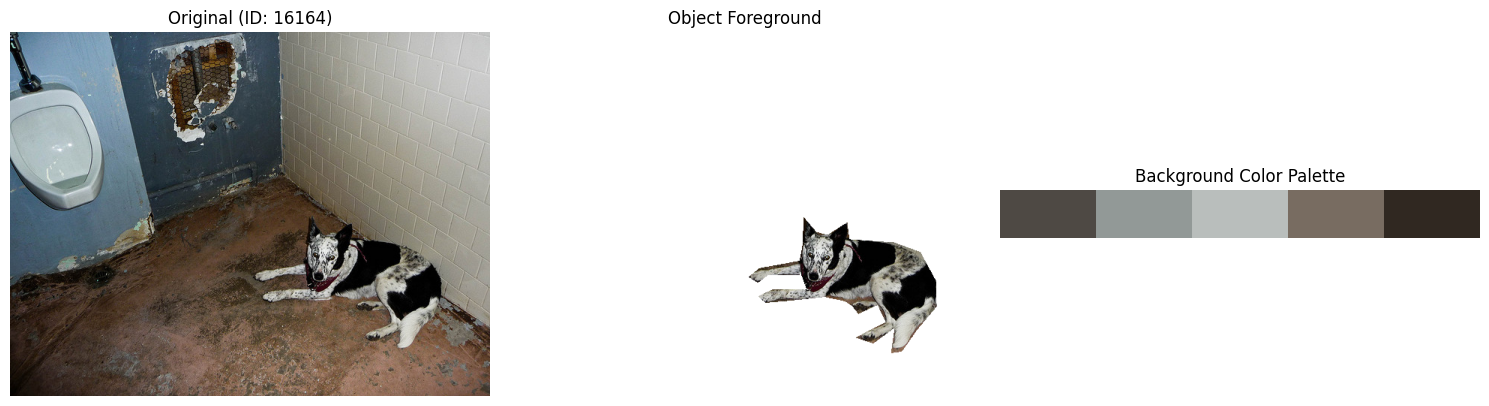

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


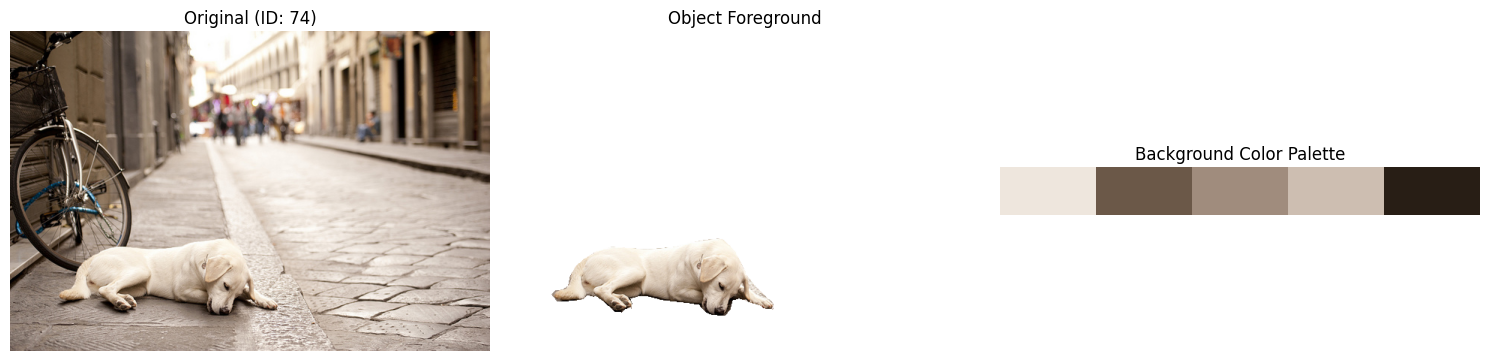

In [14]:
imgid_to_data_dict = {}

for i in range(3):  # Visualize first 3
    ann = valid_anns[i]
    img_id = ann['image_id']
    filename = imgid_to_filename_dict[img_id]
    
    img_path = f'/kaggle/input/coco-2017-dataset/coco2017/train2017/{filename}'
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    foreground, mask = extract_object_foreground(img, ann)
    palette = extract_color_palette(img, mask, n_colors=5)
    palette_img = visualize_palette(palette)
    
    if img_id not in imgid_to_data_dict:
        imgid_to_data_dict[img_id] = []
    imgid_to_data_dict[img_id].append({
        'foreground': foreground,
        'palette': palette,
        'mask': mask
    })
    
    visualize_sample(img, foreground, palette_img, img_id)

# Dataset creation using helper functions

In [36]:
imgid_to_data_dict = {}

for i in range(DATASET_LENGTH):  # Visualize first DATASET_LENGTH images
    ann = valid_anns[i]
    img_id = ann['image_id']
    filename = imgid_to_filename_dict[img_id]
    
    img_path = f'/kaggle/input/coco-2017-dataset/coco2017/train2017/{filename}'
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    foreground, mask = extract_object_foreground(img, ann)
    palette = extract_color_palette(img, mask, n_colors=5)
    palette_img = visualize_palette(palette)
    
    if img_id not in imgid_to_data_dict:
        imgid_to_data_dict[img_id] = []
    imgid_to_data_dict[img_id].append({
        'foreground': foreground,
        'palette': palette,
        'mask': mask
    })

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:8

In [37]:
#Extract the captions corresponding to a specific image
#For every valid image, find appropriate caption using image_id

with open('/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json') as f:
    captions_data = json.load(f)

# Create caption lookup (image_id -> list of captions)
img_to_captions_dict = {}
for cap in captions_data['annotations']:
    img_id = cap['image_id']
    if img_id not in img_to_captions_dict:
        img_to_captions_dict[img_id] = []   #Add a new img_id to dictionary
    img_to_captions_dict[img_id].append(cap['caption'])  #Add captions corresponding to new image

len(img_to_captions_dict)

118287

In [38]:
dataset = []

for ann in valid_anns:
    img_id = ann['image_id']
    
    if img_id in imgid_to_filename_dict and img_id in img_to_captions_dict and img_id in imgid_to_data_dict:
        caption = img_to_captions_dict[img_id][0]
        
        filename = imgid_to_filename_dict[img_id]
        img_path = f'/kaggle/input/coco-2017-dataset/coco2017/train2017/{filename}'
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        data = imgid_to_data_dict[img_id][0]
        
        dataset.append({
            'image_id': img_id,
            'img': img,  # Full original image (target output)
            'object_foreground': data['foreground'],
            'color_palette': data['palette'],
            'text_prompt': caption
        })

print(f"Camouflage dataset size: {len(dataset)}")

Camouflage dataset size: 302


A man on a bicycle rides with his dog as a passenger in the back.
225919


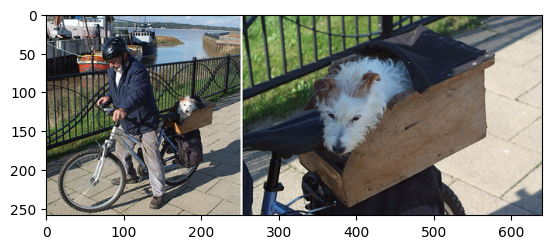

In [39]:
print(dataset[6]['text_prompt'])
print(dataset[6]['image_id'])
plt.imshow(dataset[6]['object_foreground'])
# plt.imshow(dataset[6]['color_palette'])
plt.imshow(dataset[6]['img'])

In [40]:
import pickle

with open("coco_camouflage_dataset.pkl", "wb") as f:
    pickle.dump(dataset, f)